In [1]:
# 주의! ray를 tensorflow보다 먼저 import하면 오류가 발생할 수 있습니다
import io, json, os, math

import tensorflow as tf
from tensorflow.keras.layers import Add, Concatenate, Lambda
from tensorflow.keras.layers import Input, Conv2D, ReLU, MaxPool2D
from tensorflow.keras.layers import UpSampling2D, ZeroPadding2D
from tensorflow.keras.layers import BatchNormalization
import ray

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

PROJECT_PATH = '/home/minho/Desktop/aiffel/pose_estimation'
IMAGE_PATH = os.path.join(PROJECT_PATH, 'images')
MODEL_PATH = os.path.join(PROJECT_PATH, 'models')
TFRECORD_PATH = os.path.join(PROJECT_PATH, 'tfrecords_mpii')
TRAIN_JSON = os.path.join(PROJECT_PATH, 'mpii_human_pose_v1_u12_2', 'train.json')
VALID_JSON = os.path.join(PROJECT_PATH, 'mpii_human_pose_v1_u12_2', 'validation.json')

print('슝=3')

2025-03-19 02:56:35.772115: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-19 02:56:35.782772: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-19 02:56:35.795639: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-19 02:56:35.795682: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-19 02:56:35.804737: I tensorflow/core/platform/cpu_feature_gua

슝=3


In [2]:
with open(TRAIN_JSON) as train_json:
    train_annos = json.load(train_json)
    json_formatted_str = json.dumps(train_annos[0], indent=2)
    print(json_formatted_str)

{
  "joints_vis": [
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1
  ],
  "joints": [
    [
      620.0,
      394.0
    ],
    [
      616.0,
      269.0
    ],
    [
      573.0,
      185.0
    ],
    [
      647.0,
      188.0
    ],
    [
      661.0,
      221.0
    ],
    [
      656.0,
      231.0
    ],
    [
      610.0,
      187.0
    ],
    [
      647.0,
      176.0
    ],
    [
      637.0201,
      189.8183
    ],
    [
      695.9799,
      108.1817
    ],
    [
      606.0,
      217.0
    ],
    [
      553.0,
      161.0
    ],
    [
      601.0,
      167.0
    ],
    [
      692.0,
      185.0
    ],
    [
      693.0,
      240.0
    ],
    [
      688.0,
      313.0
    ]
  ],
  "image": "015601864.jpg",
  "scale": 3.021046,
  "center": [
    594.0,
    257.0
  ]
}


In [3]:
def parse_one_annotation(anno, image_dir):
    filename = anno['image']
    joints = anno['joints']
    joints_visibility = anno['joints_vis']
    annotation = {
        'filename': filename,
        'filepath': os.path.join(image_dir, filename),
        'joints_visibility': joints_visibility,
        'joints': joints,
        'center': anno['center'],
        'scale' : anno['scale']
    }
    return annotation

print('슝=3')

슝=3


In [4]:
with open(TRAIN_JSON) as train_json:
    train_annos = json.load(train_json)
    test = parse_one_annotation(train_annos[0], IMAGE_PATH)
    print(test)

{'filename': '015601864.jpg', 'filepath': '/home/minho/Desktop/aiffel/pose_estimation/images/015601864.jpg', 'joints_visibility': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'joints': [[620.0, 394.0], [616.0, 269.0], [573.0, 185.0], [647.0, 188.0], [661.0, 221.0], [656.0, 231.0], [610.0, 187.0], [647.0, 176.0], [637.0201, 189.8183], [695.9799, 108.1817], [606.0, 217.0], [553.0, 161.0], [601.0, 167.0], [692.0, 185.0], [693.0, 240.0], [688.0, 313.0]], 'center': [594.0, 257.0], 'scale': 3.021046}


In [5]:
def generate_tfexample(anno):

    # byte 인코딩을 위한 함수
    def _bytes_feature(value):
        if isinstance(value, type(tf.constant(0))):
            value = value.numpy()
        return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

    filename = anno['filename']
    filepath = anno['filepath']
    with open(filepath, 'rb') as image_file:
        content = image_file.read()

    image = Image.open(filepath)
    if image.format != 'JPEG' or image.mode != 'RGB':
        image_rgb = image.convert('RGB')
        with io.BytesIO() as output:
            image_rgb.save(output, format="JPEG", quality=95)
            content = output.getvalue()

    width, height = image.size
    depth = 3

    c_x = int(anno['center'][0])
    c_y = int(anno['center'][1])
    scale = anno['scale']

    x = [
        int(joint[0]) if joint[0] >= 0 else int(joint[0]) 
        for joint in anno['joints']
    ]
    y = [
        int(joint[1]) if joint[1] >= 0 else int(joint[0]) 
        for joint in anno['joints']
    ]

    v = [0 if joint_v == 0 else 2 for joint_v in anno['joints_visibility']]

    feature = {
        'image/height':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[height])),
        'image/width':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[width])),
        'image/depth':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[depth])),
        'image/object/parts/x':
        tf.train.Feature(int64_list=tf.train.Int64List(value=x)),
        'image/object/parts/y':
        tf.train.Feature(int64_list=tf.train.Int64List(value=y)),
        'image/object/center/x': 
        tf.train.Feature(int64_list=tf.train.Int64List(value=[c_x])),
        'image/object/center/y': 
        tf.train.Feature(int64_list=tf.train.Int64List(value=[c_y])),
        'image/object/scale':
        tf.train.Feature(float_list=tf.train.FloatList(value=[scale])),
        'image/object/parts/v':
        tf.train.Feature(int64_list=tf.train.Int64List(value=v)),
        'image/encoded':
        _bytes_feature(content),
        'image/filename':
        _bytes_feature(filename.encode())
    }

    return tf.train.Example(features=tf.train.Features(feature=feature))

print('슝=3')

슝=3


In [6]:
def chunkify(l, n):
    size = len(l) // n
    start = 0
    results = []
    for i in range(n):
        results.append(l[start:start + size])
        start += size
    return results

print('슝=3')

슝=3


In [7]:
test_chunks = chunkify([0] * 1000, 64)
print(test_chunks)
print(len(test_chunks))
print(len(test_chunks[0]))

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0,

In [8]:
@ray.remote
def build_single_tfrecord(chunk, path):
    print('start to build tf records for ' + path)

    with tf.io.TFRecordWriter(path) as writer:
        for anno in chunk:
            tf_example = generate_tfexample(anno)
            writer.write(tf_example.SerializeToString())

    print('finished building tf records for ' + path)

print('슝=3')

슝=3


In [9]:
def build_tf_records(annotations, total_shards, split):
    chunks = chunkify(annotations, total_shards)
    futures = [
        build_single_tfrecord.remote(
            chunk, '{}/{}_{}_of_{}.tfrecords'.format(
                TFRECORD_PATH,
                split,
                str(i + 1).zfill(4),
                str(total_shards).zfill(4),
            )) for i, chunk in enumerate(chunks)
    ]
    ray.get(futures)

print('슝=3')

슝=3


In [10]:
num_train_shards = 64
num_val_shards = 8

ray.init()

print('Start to parse annotations.')
if not os.path.exists(TFRECORD_PATH):
    os.makedirs(TFRECORD_PATH)

with open(TRAIN_JSON) as train_json:
    train_annos = json.load(train_json)
    train_annotations = [
        parse_one_annotation(anno, IMAGE_PATH)
        for anno in train_annos
    ]
    print('First train annotation: ', train_annotations[0])

with open(VALID_JSON) as val_json:
    val_annos = json.load(val_json)
    val_annotations = [
        parse_one_annotation(anno, IMAGE_PATH) 
        for anno in val_annos
    ]
    print('First val annotation: ', val_annotations[0])
    
print('Start to build TF Records.')
build_tf_records(train_annotations, num_train_shards, 'train')
build_tf_records(val_annotations, num_val_shards, 'val')

print('Successfully wrote {} annotations to TF Records.'.format(
    len(train_annotations) + len(val_annotations)))

2025-03-19 02:56:49,593	INFO worker.py:1841 -- Started a local Ray instance.


Start to parse annotations.
First train annotation:  {'filename': '015601864.jpg', 'filepath': '/home/minho/Desktop/aiffel/pose_estimation/images/015601864.jpg', 'joints_visibility': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'joints': [[620.0, 394.0], [616.0, 269.0], [573.0, 185.0], [647.0, 188.0], [661.0, 221.0], [656.0, 231.0], [610.0, 187.0], [647.0, 176.0], [637.0201, 189.8183], [695.9799, 108.1817], [606.0, 217.0], [553.0, 161.0], [601.0, 167.0], [692.0, 185.0], [693.0, 240.0], [688.0, 313.0]], 'center': [594.0, 257.0], 'scale': 3.021046}
First val annotation:  {'filename': '005808361.jpg', 'filepath': '/home/minho/Desktop/aiffel/pose_estimation/images/005808361.jpg', 'joints_visibility': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'joints': [[804.0, 711.0], [816.0, 510.0], [908.0, 438.0], [1040.0, 454.0], [906.0, 528.0], [883.0, 707.0], [974.0, 446.0], [985.0, 253.0], [982.7591, 235.9694], [962.2409, 80.0306], [869.0, 214.0], [798.0, 340.0], [902.0, 253.0], [1067.0,

(pid=85228) 2025-03-19 02:56:50.784208: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
(pid=85228) 2025-03-19 02:56:50.798232: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=85228) 2025-03-19 02:56:50.817806: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=85228) 2025-03-19 02:56:50.817833: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=85228) 2025-03-19

(build_single_tfrecord pid=85227) start to build tf records for /home/minho/Desktop/aiffel/pose_estimation/tfrecords_mpii/train_0010_of_0064.tfrecords


(build_single_tfrecord pid=85227) 2025-03-19 02:56:52.506006: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
(build_single_tfrecord pid=85227) 2025-03-19 02:56:52.506030: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:134] retrieving CUDA diagnostic information for host: minho-MS-7D75
(build_single_tfrecord pid=85227) 2025-03-19 02:56:52.506039: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:141] hostname: minho-MS-7D75
(build_single_tfrecord pid=85227) 2025-03-19 02:56:52.506112: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:165] libcuda reported version is: 550.120.0
(build_single_tfrecord pid=85227) 2025-03-19 02:56:52.506131: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:169] kernel reported version is: 550.120.0
(build_single_tfrecord pid=85227) 2025-03-19 02:56:52.506140: I external/local_xla/xla/stream_ex

(build_single_tfrecord pid=85232) finished building tf records for /home/minho/Desktop/aiffel/pose_estimation/tfrecords_mpii/train_0003_of_0064.tfrecords
(build_single_tfrecord pid=85229) start to build tf records for /home/minho/Desktop/aiffel/pose_estimation/tfrecords_mpii/train_0062_of_0064.tfrecords [repeated 61x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)
(build_single_tfrecord pid=85228) finished building tf records for /home/minho/Desktop/aiffel/pose_estimation/tfrecords_mpii/val_0007_of_0008.tfrecords [repeated 64x across cluster]
Successfully wrote 25204 annotations to TF Records.


(build_single_tfrecord pid=85237) finished building tf records for /home/minho/Desktop/aiffel/pose_estimation/tfrecords_mpii/val_0006_of_0008.tfrecords


In [11]:
def parse_tfexample(example):
    image_feature_description = {
        'image/height': tf.io.FixedLenFeature([], tf.int64),
        'image/width': tf.io.FixedLenFeature([], tf.int64),
        'image/depth': tf.io.FixedLenFeature([], tf.int64),
        'image/object/parts/x': tf.io.VarLenFeature(tf.int64),
        'image/object/parts/y': tf.io.VarLenFeature(tf.int64),
        'image/object/parts/v': tf.io.VarLenFeature(tf.int64),
        'image/object/center/x': tf.io.FixedLenFeature([], tf.int64),
        'image/object/center/y': tf.io.FixedLenFeature([], tf.int64),
        'image/object/scale': tf.io.FixedLenFeature([], tf.float32),
        'image/encoded': tf.io.FixedLenFeature([], tf.string),
        'image/filename': tf.io.FixedLenFeature([], tf.string),
    }
    return tf.io.parse_single_example(example, image_feature_description)

print('슝=3')

슝=3


In [12]:
def crop_roi(image, features, margin=0.2):
    img_shape = tf.shape(image)
    img_height = img_shape[0]
    img_width = img_shape[1]
    img_depth = img_shape[2]

    keypoint_x = tf.cast(tf.sparse.to_dense(features['image/object/parts/x']), dtype=tf.int32)
    keypoint_y = tf.cast(tf.sparse.to_dense(features['image/object/parts/y']), dtype=tf.int32)
    center_x = features['image/object/center/x']
    center_y = features['image/object/center/y']
    body_height = features['image/object/scale'] * 200.0

    # keypoint 중 유효한값(visible = 1) 만 사용합니다.
    masked_keypoint_x = tf.boolean_mask(keypoint_x, keypoint_x > 0)
    masked_keypoint_y = tf.boolean_mask(keypoint_y, keypoint_y > 0)

    # min, max 값을 찾습니다.
    keypoint_xmin = tf.reduce_min(masked_keypoint_x)
    keypoint_xmax = tf.reduce_max(masked_keypoint_x)
    keypoint_ymin = tf.reduce_min(masked_keypoint_y)
    keypoint_ymax = tf.reduce_max(masked_keypoint_y)

    # 높이 값을 이용해서 x, y 위치를 재조정 합니다. 박스를 정사각형으로 사용하기 위해 아래와 같이 사용합니다.
    xmin = keypoint_xmin - tf.cast(body_height * margin, dtype=tf.int32)
    xmax = keypoint_xmax + tf.cast(body_height * margin, dtype=tf.int32)
    ymin = keypoint_ymin - tf.cast(body_height * margin, dtype=tf.int32)
    ymax = keypoint_ymax + tf.cast(body_height * margin, dtype=tf.int32)

    # 이미지 크기를 벗어나는 점을 재조정 해줍니다.
    effective_xmin = xmin if xmin > 0 else 0
    effective_ymin = ymin if ymin > 0 else 0
    effective_xmax = xmax if xmax < img_width else img_width
    effective_ymax = ymax if ymax < img_height else img_height
    effective_height = effective_ymax - effective_ymin
    effective_width = effective_xmax - effective_xmin

    image = image[effective_ymin:effective_ymax, effective_xmin:effective_xmax, :]
    new_shape = tf.shape(image)
    new_height = new_shape[0]
    new_width = new_shape[1]

    effective_keypoint_x = (keypoint_x - effective_xmin) / new_width
    effective_keypoint_y = (keypoint_y - effective_ymin) / new_height

    return image, effective_keypoint_x, effective_keypoint_y

print('슝=3')

슝=3


In [13]:
def generate_2d_guassian(height, width, y0, x0, visibility=2, sigma=1, scale=12):
    heatmap = tf.zeros((height, width))

    xmin = x0 - 3 * sigma
    ymin = y0 - 3 * sigma
    xmax = x0 + 3 * sigma
    ymax = y0 + 3 * sigma
    
    if xmin >= width or ymin >= height or xmax < 0 or ymax < 0 or visibility == 0:
        return heatmap

    size = 6 * sigma + 1
    x, y = tf.meshgrid(tf.range(0, 6 * sigma + 1, 1), tf.range(0, 6 * sigma + 1, 1), indexing='xy')

    center_x = size // 2
    center_y = size // 2

    gaussian_patch = tf.cast(tf.math.exp(
        -(tf.math.square(x - center_x) + tf.math.square(y - center_y)) / (tf.math.square(sigma) * 2)) * scale,
                             dtype=tf.float32)

    patch_xmin = tf.math.maximum(0, -xmin)
    patch_ymin = tf.math.maximum(0, -ymin)
    patch_xmax = tf.math.minimum(xmax, width) - xmin
    patch_ymax = tf.math.minimum(ymax, height) - ymin

    heatmap_xmin = tf.math.maximum(0, xmin)
    heatmap_ymin = tf.math.maximum(0, ymin)
    heatmap_xmax = tf.math.minimum(xmax, width)
    heatmap_ymax = tf.math.minimum(ymax, height)

    indices = tf.TensorArray(tf.int32, 1, dynamic_size=True)
    updates = tf.TensorArray(tf.float32, 1, dynamic_size=True)

    count = 0

    for j in tf.range(patch_ymin, patch_ymax):
        for i in tf.range(patch_xmin, patch_xmax):
            indices = indices.write(count, [heatmap_ymin + j, heatmap_xmin + i])
            updates = updates.write(count, gaussian_patch[j][i])
            count += 1

    heatmap = tf.tensor_scatter_nd_update(heatmap, indices.stack(), updates.stack())

    return heatmap

def make_heatmaps(features, keypoint_x, keypoint_y, heatmap_shape):
    v = tf.cast(tf.sparse.to_dense(features['image/object/parts/v']), dtype=tf.float32)
    x = tf.cast(tf.math.round(keypoint_x * heatmap_shape[0]), dtype=tf.int32)
    y = tf.cast(tf.math.round(keypoint_y * heatmap_shape[1]), dtype=tf.int32)

    num_heatmap = heatmap_shape[2]
    heatmap_array = tf.TensorArray(tf.float32, 16)

    for i in range(num_heatmap):
        gaussian = self.generate_2d_guassian(heatmap_shape[1], heatmap_shape[0], y[i], x[i], v[i])
        heatmap_array = heatmap_array.write(i, gaussian)

    heatmaps = heatmap_array.stack()
    heatmaps = tf.transpose(heatmaps, perm=[1, 2, 0])  # change to (64, 64, 16)

    return heatmaps

print('슝=3')

슝=3


In [14]:
class Preprocessor(object):
    def __init__(self,
                 image_shape=(256, 256, 3),
                 heatmap_shape=(64, 64, 16),
                 is_train=False):
        self.is_train = is_train
        self.image_shape = image_shape
        self.heatmap_shape = heatmap_shape

    def __call__(self, example):
        features = self.parse_tfexample(example)
        image = tf.io.decode_jpeg(features['image/encoded'])

        if self.is_train:
            random_margin = tf.random.uniform([1], 0.1, 0.3)[0]
            image, keypoint_x, keypoint_y = self.crop_roi(image, features, margin=random_margin)
            image = tf.image.resize(image, self.image_shape[0:2])
        else:
            image, keypoint_x, keypoint_y = self.crop_roi(image, features)
            image = tf.image.resize(image, self.image_shape[0:2])

        image = tf.cast(image, tf.float32) / 127.5 - 1
        heatmaps = self.make_heatmaps(features, keypoint_x, keypoint_y, self.heatmap_shape)

        return image, heatmaps

        
    def crop_roi(self, image, features, margin=0.2):
        img_shape = tf.shape(image)
        img_height = img_shape[0]
        img_width = img_shape[1]
        img_depth = img_shape[2]

        keypoint_x = tf.cast(tf.sparse.to_dense(features['image/object/parts/x']), dtype=tf.int32)
        keypoint_y = tf.cast(tf.sparse.to_dense(features['image/object/parts/y']), dtype=tf.int32)
        center_x = features['image/object/center/x']
        center_y = features['image/object/center/y']
        body_height = features['image/object/scale'] * 200.0
        
        masked_keypoint_x = tf.boolean_mask(keypoint_x, keypoint_x > 0)
        masked_keypoint_y = tf.boolean_mask(keypoint_y, keypoint_y > 0)
        
        keypoint_xmin = tf.reduce_min(masked_keypoint_x)
        keypoint_xmax = tf.reduce_max(masked_keypoint_x)
        keypoint_ymin = tf.reduce_min(masked_keypoint_y)
        keypoint_ymax = tf.reduce_max(masked_keypoint_y)
        
        xmin = keypoint_xmin - tf.cast(body_height * margin, dtype=tf.int32)
        xmax = keypoint_xmax + tf.cast(body_height * margin, dtype=tf.int32)
        ymin = keypoint_ymin - tf.cast(body_height * margin, dtype=tf.int32)
        ymax = keypoint_ymax + tf.cast(body_height * margin, dtype=tf.int32)
        
        effective_xmin = xmin if xmin > 0 else 0
        effective_ymin = ymin if ymin > 0 else 0
        effective_xmax = xmax if xmax < img_width else img_width
        effective_ymax = ymax if ymax < img_height else img_height
        effective_height = effective_ymax - effective_ymin
        effective_width = effective_xmax - effective_xmin

        image = image[effective_ymin:effective_ymax, effective_xmin:effective_xmax, :]
        new_shape = tf.shape(image)
        new_height = new_shape[0]
        new_width = new_shape[1]
        
        effective_keypoint_x = (keypoint_x - effective_xmin) / new_width
        effective_keypoint_y = (keypoint_y - effective_ymin) / new_height
        
        return image, effective_keypoint_x, effective_keypoint_y
        
    
    def generate_2d_guassian(self, height, width, y0, x0, visibility=2, sigma=1, scale=12):
        
        heatmap = tf.zeros((height, width))

        xmin = x0 - 3 * sigma
        ymin = y0 - 3 * sigma
        xmax = x0 + 3 * sigma
        ymax = y0 + 3 * sigma

        if xmin >= width or ymin >= height or xmax < 0 or ymax <0 or visibility == 0:
            return heatmap

        size = 6 * sigma + 1
        x, y = tf.meshgrid(tf.range(0, 6*sigma+1, 1), tf.range(0, 6*sigma+1, 1), indexing='xy')

        center_x = size // 2
        center_y = size // 2

        gaussian_patch = tf.cast(tf.math.exp(-(tf.square(x - center_x) + tf.math.square(y - center_y)) / (tf.math.square(sigma) * 2)) * scale, dtype=tf.float32)

        patch_xmin = tf.math.maximum(0, -xmin)
        patch_ymin = tf.math.maximum(0, -ymin)
        patch_xmax = tf.math.minimum(xmax, width) - xmin
        patch_ymax = tf.math.minimum(ymax, height) - ymin

        heatmap_xmin = tf.math.maximum(0, xmin)
        heatmap_ymin = tf.math.maximum(0, ymin)
        heatmap_xmax = tf.math.minimum(xmax, width)
        heatmap_ymax = tf.math.minimum(ymax, height)

        indices = tf.TensorArray(tf.int32, 1, dynamic_size=True)
        updates = tf.TensorArray(tf.float32, 1, dynamic_size=True)

        count = 0

        for j in tf.range(patch_ymin, patch_ymax):
            for i in tf.range(patch_xmin, patch_xmax):
                indices = indices.write(count, [heatmap_ymin+j, heatmap_xmin+i])
                updates = updates.write(count, gaussian_patch[j][i])
                count += 1
                
        heatmap = tf.tensor_scatter_nd_update(heatmap, indices.stack(), updates.stack())

        return heatmap


    def make_heatmaps(self, features, keypoint_x, keypoint_y, heatmap_shape):
        v = tf.cast(tf.sparse.to_dense(features['image/object/parts/v']), dtype=tf.float32)
        x = tf.cast(tf.math.round(keypoint_x * heatmap_shape[0]), dtype=tf.int32)
        y = tf.cast(tf.math.round(keypoint_y * heatmap_shape[1]), dtype=tf.int32)
        
        num_heatmap = heatmap_shape[2]
        heatmap_array = tf.TensorArray(tf.float32, 16)

        for i in range(num_heatmap):
            gaussian = self.generate_2d_guassian(heatmap_shape[1], heatmap_shape[0], y[i], x[i], v[i])
            heatmap_array = heatmap_array.write(i, gaussian)
        
        heatmaps = heatmap_array.stack()
        heatmaps = tf.transpose(heatmaps, perm=[1, 2, 0]) # change to (64, 64, 16)
        
        return heatmaps

    def parse_tfexample(self, example):
        image_feature_description = {
            'image/height': tf.io.FixedLenFeature([], tf.int64),
            'image/width': tf.io.FixedLenFeature([], tf.int64),
            'image/depth': tf.io.FixedLenFeature([], tf.int64),
            'image/object/parts/x': tf.io.VarLenFeature(tf.int64),
            'image/object/parts/y': tf.io.VarLenFeature(tf.int64),
            'image/object/parts/v': tf.io.VarLenFeature(tf.int64),
            'image/object/center/x': tf.io.FixedLenFeature([], tf.int64),
            'image/object/center/y': tf.io.FixedLenFeature([], tf.int64),
            'image/object/scale': tf.io.FixedLenFeature([], tf.float32),
            'image/encoded': tf.io.FixedLenFeature([], tf.string),
            'image/filename': tf.io.FixedLenFeature([], tf.string),
        }
        return tf.io.parse_single_example(example,
                                          image_feature_description)

print('슝=3')

슝=3


In [15]:
def BottleneckBlock(inputs, filters, strides=1, downsample=False, name=None):
    identity = inputs
    if downsample:
        identity = Conv2D(
            filters=filters,
            kernel_size=1,
            strides=strides,
            padding='same',
            kernel_initializer='he_normal')(inputs)

    x = BatchNormalization(momentum=0.9)(inputs)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters // 2,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(x)

    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters // 2,
        kernel_size=3,
        strides=strides,
        padding='same',
        kernel_initializer='he_normal')(x)

    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(x)

    x = Add()([identity, x])
    return x

print('슝=3')

슝=3


In [16]:
def HourglassModule(inputs, order, filters, num_residual):
    
    up1 = BottleneckBlock(inputs, filters, downsample=False)
    for i in range(num_residual):
        up1 = BottleneckBlock(up1, filters, downsample=False)

    low1 = MaxPool2D(pool_size=2, strides=2)(inputs)
    for i in range(num_residual):
        low1 = BottleneckBlock(low1, filters, downsample=False)

    low2 = low1
    if order > 1:
        low2 = HourglassModule(low1, order - 1, filters, num_residual)
    else:
        for i in range(num_residual):
            low2 = BottleneckBlock(low2, filters, downsample=False)

    low3 = low2
    for i in range(num_residual):
        low3 = BottleneckBlock(low3, filters, downsample=False)

    up2 = UpSampling2D(size=2)(low3)

    return up2 + up1

print('슝=3')

슝=3


In [17]:
def LinearLayer(inputs, filters):
    x = Conv2D(
        filters=filters,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(inputs)
    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    return x

print('슝=3')

슝=3


In [18]:
def StackedHourglassNetwork(
        input_shape=(256, 256, 3), 
        num_stack=4, 
        num_residual=1,
        num_heatmap=16):
    
    inputs = Input(shape=input_shape)

    x = Conv2D(
        filters=64,
        kernel_size=7,
        strides=2,
        padding='same',
        kernel_initializer='he_normal')(inputs)
    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = BottleneckBlock(x, 128, downsample=True)
    x = MaxPool2D(pool_size=2, strides=2)(x)
    x = BottleneckBlock(x, 128, downsample=False)
    x = BottleneckBlock(x, 256, downsample=True)

    ys = []
    for i in range(num_stack):
        x = HourglassModule(x, order=4, filters=256, num_residual=num_residual)
        for i in range(num_residual):
            x = BottleneckBlock(x, 256, downsample=False)

        x = LinearLayer(x, 256)

        y = Conv2D(
            filters=num_heatmap,
            kernel_size=1,
            strides=1,
            padding='same',
            kernel_initializer='he_normal')(x)
        ys.append(y)

        if i < num_stack - 1:
            y_intermediate_1 = Conv2D(filters=256, kernel_size=1, strides=1)(x)
            y_intermediate_2 = Conv2D(filters=256, kernel_size=1, strides=1)(y)
            x = Add()([y_intermediate_1, y_intermediate_2])

    return tf.keras.Model(inputs, ys, name='stacked_hourglass')

print('슝=3')

슝=3


In [27]:
IMAGE_SHAPE = (256, 256, 3)
HEATMAP_SIZE = (64, 64)

def create_dataset(tfrecords, batch_size, num_heatmap, is_train):
    preprocess = Preprocessor(
        IMAGE_SHAPE, (HEATMAP_SIZE[0], HEATMAP_SIZE[1], num_heatmap), is_train)

    dataset = tf.data.Dataset.list_files(tfrecords)
    dataset = tf.data.TFRecordDataset(dataset)
    dataset = dataset.map(
        preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    if is_train:
        dataset = dataset.shuffle(batch_size)

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset

print('슝=3')

슝=3


In [28]:
class Trainer(object):
    def __init__(self,
                 model,
                 epochs,
                 global_batch_size,
                 strategy,
                 initial_learning_rate):
        self.model = model
        self.epochs = epochs
        self.strategy = strategy
        self.global_batch_size = global_batch_size
        self.loss_object = tf.keras.losses.MeanSquaredError(
            reduction=tf.keras.losses.Reduction.NONE)
        self.optimizer = tf.keras.optimizers.Adam(
            learning_rate=initial_learning_rate)

        self.current_learning_rate = initial_learning_rate
        self.last_val_loss = math.inf
        self.lowest_val_loss = math.inf
        self.patience_count = 0
        self.max_patience = 10
        self.best_model = None
        
        # history 객체: 에포크별 train_loss와 val_loss 기록
        self.history = {"train_loss": [], "val_loss": []}

    def lr_decay(self):
        if self.patience_count >= self.max_patience:
            self.current_learning_rate /= 10.0
            self.patience_count = 0
        elif self.last_val_loss == self.lowest_val_loss:
            self.patience_count = 0
        self.patience_count += 1
        self.optimizer.learning_rate = self.current_learning_rate

    def lr_decay_step(self, epoch):
        if epoch in [25, 50, 75]:
            self.current_learning_rate /= 10.0
        self.optimizer.learning_rate = self.current_learning_rate

    def compute_loss(self, labels, outputs):
        # labels를 float32로 캐스팅합니다.
        labels = tf.cast(labels, tf.float32)
        # 초기 loss 값을 float32 0.0으로 선언합니다.
        loss = tf.constant(0.0, dtype=tf.float32)
        for output in outputs:
            weights = tf.cast(labels > 0, dtype=tf.float32) * 81 + 1
            loss += tf.math.reduce_mean(tf.math.square(labels - output) * weights) * (1.0 / self.global_batch_size)
        return loss

    def train_step(self, inputs):
        images, labels = inputs
        with tf.GradientTape() as tape:
            outputs = self.model(images, training=True)
            loss = self.compute_loss(labels, outputs)
        grads = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))
        return loss

    def val_step(self, inputs):
        images, labels = inputs
        outputs = self.model(images, training=False)
        loss = self.compute_loss(labels, outputs)
        return loss

    def run(self, train_dist_dataset, val_dist_dataset):
        @tf.function
        def distributed_train_epoch(dataset):
            tf.print('Start distributed training...')
            total_loss = 0.0
            num_train_batches = 0.0
            for one_batch in dataset:
                per_replica_loss = self.strategy.run(self.train_step, args=(one_batch,))
                batch_loss = self.strategy.reduce(tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None)
                total_loss += batch_loss
                num_train_batches += 1
                tf.print('Trained batch', num_train_batches, 'batch loss', batch_loss,
                         'epoch total loss', total_loss / num_train_batches)
            return total_loss, num_train_batches

        @tf.function
        def distributed_val_epoch(dataset):
            total_loss = 0.0
            num_val_batches = 0.0
            for one_batch in dataset:
                per_replica_loss = self.strategy.run(self.val_step, args=(one_batch,))
                num_val_batches += 1
                batch_loss = self.strategy.reduce(tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None)
                tf.print('Validated batch', num_val_batches, 'batch loss', batch_loss)
                if not tf.math.is_nan(batch_loss):
                    total_loss += batch_loss
                else:
                    num_val_batches -= 1
            return total_loss, num_val_batches

        for epoch in range(1, self.epochs + 1):
            self.lr_decay()
            print('Start epoch {} with learning rate {}'.format(epoch, self.current_learning_rate))

            train_total_loss, num_train_batches = distributed_train_epoch(train_dist_dataset)
            train_loss = train_total_loss / num_train_batches
            print('Epoch {} train loss {}'.format(epoch, train_loss))
            self.history["train_loss"].append(train_loss.numpy())

            val_total_loss, num_val_batches = distributed_val_epoch(val_dist_dataset)
            val_loss = val_total_loss / num_val_batches
            print('Epoch {} val loss {}'.format(epoch, val_loss))
            self.history["val_loss"].append(val_loss.numpy())

            if val_loss < self.lowest_val_loss:
                self.save_model(epoch, val_loss)
                self.lowest_val_loss = val_loss
            self.last_val_loss = val_loss

        return self.history

    def save_model(self, epoch, loss):
        model_name = MODEL_PATH + '/model-epoch-{}-loss-{:.4f}.weights.h5'.format(epoch, loss)
        self.model.save_weights(model_name)
        self.best_model = model_name
        print("Model {} saved.".format(model_name))

print('슝=3')

슝=3


# 같은 train 메서드를 이용하여 학습하기 위해, 로스 계산 시 float로 캐스팅하는 부분을 추가했다.

In [29]:
def train(epochs, learning_rate, num_heatmap, batch_size, train_tfrecords, val_tfrecords):
    strategy = tf.distribute.MirroredStrategy()
    global_batch_size = strategy.num_replicas_in_sync * batch_size
    train_dataset = create_dataset(
        train_tfrecords, global_batch_size, num_heatmap, is_train=True)
    val_dataset = create_dataset(
        val_tfrecords, global_batch_size, num_heatmap, is_train=False)

    if not os.path.exists(MODEL_PATH):
        os.makedirs(MODEL_PATH)

    with strategy.scope():
        train_dist_dataset = strategy.experimental_distribute_dataset(
            train_dataset)
        val_dist_dataset = strategy.experimental_distribute_dataset(
            val_dataset)

        model = StackedHourglassNetwork(IMAGE_SHAPE, 4, 1, num_heatmap)

        trainer = Trainer(
            model,
            epochs,
            global_batch_size,
            strategy,
            initial_learning_rate=learning_rate)

        print('Start training...')
        return trainer.run(train_dist_dataset, val_dist_dataset)

print('슝=3')

슝=3


In [30]:
def build_simple_baseline(input_shape, num_heatmaps):
    """
    SimpleBaseline 모델 구성 (출력 해상도는 TFRecord로부터 추출된 label과 동일해야 함)
    예를 들어, 입력이 256x256이면 downsampling 후 (64,64) 크기의 feature map에 대해 
    마지막 1x1 Conv로 num_heatmaps 채널을 예측하도록 구성합니다.
    """
    inputs = tf.keras.Input(shape=input_shape)
    
    # 초기 다운샘플링: 7x7 conv, strides=2, 그리고 maxpooling
    x = tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same', activation='relu')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2, padding='same')(x)  # 결과: (64,64,64) if input is 256x256
    
    # 여러 Conv2D 레이어 (해상도 유지)
    for filters in [64, 128, 256]:
        x = tf.keras.layers.Conv2D(filters, kernel_size=3, padding='same', activation='relu')(x)
        x = tf.keras.layers.BatchNormalization()(x)
    
    # 출력: 1x1 Conv로 num_heatmaps 채널 예측 (출력 해상도: (64,64,num_heatmaps))
    outputs = tf.keras.layers.Conv2D(num_heatmaps, kernel_size=1, activation='linear')(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

def train_sb(epochs, learning_rate, num_heatmap, batch_size, train_tfrecords, val_tfrecords):
    # GPU 분산 훈련 전략 (MirroredStrategy 사용)
    strategy = tf.distribute.MirroredStrategy()
    global_batch_size = strategy.num_replicas_in_sync * batch_size
    
    # TFRecord 파일들을 와일드카드 패턴으로 로드 (예: "train_*.tfrecords")
    train_dataset = create_dataset(train_tfrecords, global_batch_size, num_heatmap, is_train=True)
    val_dataset = create_dataset(val_tfrecords, global_batch_size, num_heatmap, is_train=False)
    
    if not os.path.exists(MODEL_PATH):
        os.makedirs(MODEL_PATH)
    
    with strategy.scope():
        train_dist_dataset = strategy.experimental_distribute_dataset(train_dataset)
        val_dist_dataset = strategy.experimental_distribute_dataset(val_dataset)
        
        # SimpleBaseline 모델 생성
        model = build_simple_baseline(IMAGE_SHAPE, num_heatmap)
        
        # Trainer 클래스는 앞서 구현한 대로 history 객체를 반환하도록 수정되어 있음
        trainer = Trainer(model, epochs, global_batch_size, strategy, learning_rate)
        print('Start training SimpleBaseline model...')
        history = trainer.run(train_dist_dataset, val_dist_dataset)
    
    return history

In [31]:
EPOCHS = 10
LEARNING_RATE = 0.001
NUM_HEATMAP = 16
BATCH_SIZE = 16

# 생성된 TFRecord 파일 경로 설정
train_tfrecords = os.path.join(TFRECORD_PATH, "train_*.tfrecords")
val_tfrecords = os.path.join(TFRECORD_PATH, "val_*.tfrecords")

In [34]:
# 모델 훈련 실행
history = train(EPOCHS, LEARNING_RATE, NUM_HEATMAP, BATCH_SIZE, train_tfrecords, val_tfrecords)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Start training...
Start epoch 1 with learning rate 0.001
Start distributed training...
Trained batch 1 batch loss 2.48266673 epoch total loss 2.48266673
Trained batch 2 batch loss 2.52182937 epoch total loss 2.50224805
Trained batch 3 batch loss 2.36522341 epoch total loss 2.45657325
Trained batch 4 batch loss 2.3984704 epoch total loss 2.4420476
Trained batch 5 batch loss 2.31956124 epoch total loss 2.41755033
Trained batch 6 batch loss 2.42834234 epoch total loss 2.41934896
Trained batch 7 batch loss 2.25516605 epoch total loss 2.39589429
Trained batch 8 batch loss 2.00303841 epoch total loss 2.34678721
Trained batch 9 batch loss 2.04049921 epoch total loss 2.31275511
Trained batch 10 batch loss 2.08256984 epoch total loss 2.28973651
Trained batch 11 batch loss 2.04707837 epoch total loss 2.26767683
Trained batch 12 batch loss 2.00087047 epoch total loss 2.24544287
Trained batch 13 b

2025-03-19 03:25:14.863390: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-03-19 03:25:14.863440: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


Trained batch 1388 batch loss 1.29290175 epoch total loss 1.52030337
Epoch 1 train loss 1.5203033685684204
Validated batch 1 batch loss 1.28493476
Validated batch 2 batch loss 1.43440437
Validated batch 3 batch loss 1.4480598
Validated batch 4 batch loss 1.35865903
Validated batch 5 batch loss 1.47185028
Validated batch 6 batch loss 1.51156712
Validated batch 7 batch loss 1.29794741
Validated batch 8 batch loss 1.45064735
Validated batch 9 batch loss 1.38685167
Validated batch 10 batch loss 1.47258615
Validated batch 11 batch loss 1.41917074
Validated batch 12 batch loss 1.2795105
Validated batch 13 batch loss 1.30917954
Validated batch 14 batch loss 1.4421401
Validated batch 15 batch loss 1.40162873
Validated batch 16 batch loss 1.39026904
Validated batch 17 batch loss 1.40413117
Validated batch 18 batch loss 1.39431322
Validated batch 19 batch loss 1.43902063
Validated batch 20 batch loss 1.50886416
Validated batch 21 batch loss 1.44692385
Validated batch 22 batch loss 1.4403789
Vali

2025-03-19 03:25:36.161657: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-03-19 03:25:36.161694: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


Validated batch 185 batch loss 1.55904174
Epoch 1 val loss 1.4224616289138794
Model /home/minho/Desktop/aiffel/pose_estimation/models/model-epoch-1-loss-1.4225.weights.h5 saved.
Start epoch 2 with learning rate 0.001
Start distributed training...
Trained batch 1 batch loss 1.41157377 epoch total loss 1.41157377
Trained batch 2 batch loss 1.45175028 epoch total loss 1.43166208
Trained batch 3 batch loss 1.30855966 epoch total loss 1.39062786
Trained batch 4 batch loss 1.33849967 epoch total loss 1.37759578
Trained batch 5 batch loss 1.34507692 epoch total loss 1.37109208
Trained batch 6 batch loss 1.32381022 epoch total loss 1.36321175
Trained batch 7 batch loss 1.2610333 epoch total loss 1.34861481
Trained batch 8 batch loss 1.3336674 epoch total loss 1.34674644
Trained batch 9 batch loss 1.29978776 epoch total loss 1.34152877
Trained batch 10 batch loss 1.35966086 epoch total loss 1.34334207
Trained batch 11 batch loss 1.29084635 epoch total loss 1.33856964
Trained batch 12 batch loss

2025-03-19 03:33:52.492205: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-03-19 03:33:52.492255: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


Trained batch 1388 batch loss 1.13880289 epoch total loss 1.33914804
Epoch 2 train loss 1.3391480445861816
Validated batch 1 batch loss 1.27874565
Validated batch 2 batch loss 1.17354274
Validated batch 3 batch loss 1.30219412
Validated batch 4 batch loss 1.21014631
Validated batch 5 batch loss 1.2933538
Validated batch 6 batch loss 1.30647361
Validated batch 7 batch loss 1.31139958
Validated batch 8 batch loss 1.43423915
Validated batch 9 batch loss 1.42075038
Validated batch 10 batch loss 1.32824719
Validated batch 11 batch loss 1.33824182
Validated batch 12 batch loss 1.40835166
Validated batch 13 batch loss 1.40200114
Validated batch 14 batch loss 1.38072622
Validated batch 15 batch loss 1.38516414
Validated batch 16 batch loss 1.38563073
Validated batch 17 batch loss 1.33839655
Validated batch 18 batch loss 1.20144522
Validated batch 19 batch loss 1.29891264
Validated batch 20 batch loss 1.38113618
Validated batch 21 batch loss 1.32936323
Validated batch 22 batch loss 1.34309375
V

2025-03-19 03:34:08.453132: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-03-19 03:34:08.453173: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


Model /home/minho/Desktop/aiffel/pose_estimation/models/model-epoch-2-loss-1.3121.weights.h5 saved.
Start epoch 3 with learning rate 0.001
Start distributed training...
Trained batch 1 batch loss 1.20434117 epoch total loss 1.20434117
Trained batch 2 batch loss 1.26488757 epoch total loss 1.23461437
Trained batch 3 batch loss 1.20529819 epoch total loss 1.22484231
Trained batch 4 batch loss 1.35389638 epoch total loss 1.25710583
Trained batch 5 batch loss 1.46730888 epoch total loss 1.29914641
Trained batch 6 batch loss 1.38583207 epoch total loss 1.31359398
Trained batch 7 batch loss 1.28937888 epoch total loss 1.31013477
Trained batch 8 batch loss 1.35152352 epoch total loss 1.31530833
Trained batch 9 batch loss 1.22613692 epoch total loss 1.30540037
Trained batch 10 batch loss 1.2715888 epoch total loss 1.30201936
Trained batch 11 batch loss 1.34293616 epoch total loss 1.30573905
Trained batch 12 batch loss 1.43868327 epoch total loss 1.31681776
Trained batch 13 batch loss 1.5050247

2025-03-19 03:42:24.503040: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-03-19 03:42:24.503092: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


Trained batch 1388 batch loss 1.539271 epoch total loss 1.25869739
Epoch 3 train loss 1.2586973905563354
Validated batch 1 batch loss 1.2317791
Validated batch 2 batch loss 1.24083757
Validated batch 3 batch loss 1.18792486
Validated batch 4 batch loss 1.29458368
Validated batch 5 batch loss 1.24708831
Validated batch 6 batch loss 1.29729271
Validated batch 7 batch loss 1.31594634
Validated batch 8 batch loss 1.29771233
Validated batch 9 batch loss 1.2862885
Validated batch 10 batch loss 1.2149545
Validated batch 11 batch loss 1.29638267
Validated batch 12 batch loss 1.21957064
Validated batch 13 batch loss 1.25941658
Validated batch 14 batch loss 1.35404694
Validated batch 15 batch loss 1.31517911
Validated batch 16 batch loss 1.24412012
Validated batch 17 batch loss 1.38652968
Validated batch 18 batch loss 1.10850835
Validated batch 19 batch loss 1.31125855
Validated batch 20 batch loss 1.03006113
Validated batch 21 batch loss 1.23597181
Validated batch 22 batch loss 1.30570579
Valid

2025-03-19 03:42:40.367576: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-03-19 03:42:40.367668: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


Model /home/minho/Desktop/aiffel/pose_estimation/models/model-epoch-3-loss-1.2347.weights.h5 saved.
Start epoch 4 with learning rate 0.001
Start distributed training...
Trained batch 1 batch loss 1.24992788 epoch total loss 1.24992788
Trained batch 2 batch loss 1.26227164 epoch total loss 1.2560997
Trained batch 3 batch loss 1.23461413 epoch total loss 1.24893785
Trained batch 4 batch loss 1.28478575 epoch total loss 1.25789976
Trained batch 5 batch loss 1.15569258 epoch total loss 1.23745835
Trained batch 6 batch loss 1.23535681 epoch total loss 1.23710811
Trained batch 7 batch loss 1.15414536 epoch total loss 1.2252562
Trained batch 8 batch loss 1.13585508 epoch total loss 1.21408105
Trained batch 9 batch loss 1.09155726 epoch total loss 1.20046735
Trained batch 10 batch loss 1.12560749 epoch total loss 1.19298136
Trained batch 11 batch loss 1.08963442 epoch total loss 1.18358612
Trained batch 12 batch loss 1.23080611 epoch total loss 1.1875211
Trained batch 13 batch loss 1.11253071 

2025-03-19 03:50:56.131504: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-03-19 03:50:56.131549: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


Trained batch 1388 batch loss 1.20643353 epoch total loss 1.20801687
Epoch 4 train loss 1.2080168724060059
Validated batch 1 batch loss 1.21494615
Validated batch 2 batch loss 1.08691025
Validated batch 3 batch loss 1.2213037
Validated batch 4 batch loss 1.11891139
Validated batch 5 batch loss 1.20273376
Validated batch 6 batch loss 1.26386905
Validated batch 7 batch loss 1.22052789
Validated batch 8 batch loss 1.33565187
Validated batch 9 batch loss 1.31222939
Validated batch 10 batch loss 1.2015239
Validated batch 11 batch loss 1.24798703
Validated batch 12 batch loss 1.30617225
Validated batch 13 batch loss 1.34235287
Validated batch 14 batch loss 1.32834387
Validated batch 15 batch loss 1.29018378
Validated batch 16 batch loss 1.32842958
Validated batch 17 batch loss 1.29714084
Validated batch 18 batch loss 1.14368749
Validated batch 19 batch loss 1.24551773
Validated batch 20 batch loss 1.32716906
Validated batch 21 batch loss 1.18773794
Validated batch 22 batch loss 1.21344376
Va

2025-03-19 03:51:12.060921: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-03-19 03:51:12.060955: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


Model /home/minho/Desktop/aiffel/pose_estimation/models/model-epoch-4-loss-1.2112.weights.h5 saved.
Start epoch 5 with learning rate 0.001
Start distributed training...
Trained batch 1 batch loss 1.19421244 epoch total loss 1.19421244
Trained batch 2 batch loss 1.1660527 epoch total loss 1.18013263
Trained batch 3 batch loss 1.262743 epoch total loss 1.20766938
Trained batch 4 batch loss 1.26333475 epoch total loss 1.22158575
Trained batch 5 batch loss 1.37635136 epoch total loss 1.25253892
Trained batch 6 batch loss 1.52117825 epoch total loss 1.29731214
Trained batch 7 batch loss 1.15198195 epoch total loss 1.27655065
Trained batch 8 batch loss 1.19141817 epoch total loss 1.26590919
Trained batch 9 batch loss 1.21915638 epoch total loss 1.26071441
Trained batch 10 batch loss 1.16360021 epoch total loss 1.25100303
Trained batch 11 batch loss 1.21179938 epoch total loss 1.24743903
Trained batch 12 batch loss 1.27987552 epoch total loss 1.2501421
Trained batch 13 batch loss 1.35363531 e

2025-03-19 03:59:27.631378: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-03-19 03:59:27.631424: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


Trained batch 1388 batch loss 1.16759408 epoch total loss 1.1709727
Epoch 5 train loss 1.1709727048873901
Validated batch 1 batch loss 1.05834222
Validated batch 2 batch loss 1.15227628
Validated batch 3 batch loss 1.24042273
Validated batch 4 batch loss 1.16678989
Validated batch 5 batch loss 1.28759193
Validated batch 6 batch loss 1.37742496
Validated batch 7 batch loss 1.07071495
Validated batch 8 batch loss 1.23097968
Validated batch 9 batch loss 1.16877055
Validated batch 10 batch loss 1.31084299
Validated batch 11 batch loss 1.18809044
Validated batch 12 batch loss 1.02018189
Validated batch 13 batch loss 1.07504785
Validated batch 14 batch loss 1.11836553
Validated batch 15 batch loss 1.10750663
Validated batch 16 batch loss 1.18060303
Validated batch 17 batch loss 1.12301755
Validated batch 18 batch loss 1.04727423
Validated batch 19 batch loss 1.20629644
Validated batch 20 batch loss 1.24776876
Validated batch 21 batch loss 1.27645481
Validated batch 22 batch loss 1.20474696
V

2025-03-19 03:59:43.579567: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-03-19 03:59:43.579603: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


Model /home/minho/Desktop/aiffel/pose_estimation/models/model-epoch-5-loss-1.1871.weights.h5 saved.
Start epoch 6 with learning rate 0.001
Start distributed training...
Trained batch 1 batch loss 1.11196578 epoch total loss 1.11196578
Trained batch 2 batch loss 1.35055149 epoch total loss 1.23125863
Trained batch 3 batch loss 1.21495008 epoch total loss 1.22582245
Trained batch 4 batch loss 1.24900365 epoch total loss 1.23161769
Trained batch 5 batch loss 1.30181813 epoch total loss 1.24565768
Trained batch 6 batch loss 1.38528287 epoch total loss 1.26892865
Trained batch 7 batch loss 1.16894042 epoch total loss 1.25464451
Trained batch 8 batch loss 1.2235868 epoch total loss 1.25076234
Trained batch 9 batch loss 1.15292287 epoch total loss 1.23989129
Trained batch 10 batch loss 1.13342488 epoch total loss 1.22924459
Trained batch 11 batch loss 1.24407828 epoch total loss 1.2305932
Trained batch 12 batch loss 1.24408102 epoch total loss 1.23171711
Trained batch 13 batch loss 1.2186451 

2025-03-19 04:07:59.440989: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-03-19 04:07:59.441041: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


Trained batch 1388 batch loss 1.1699748 epoch total loss 1.14374757
Epoch 6 train loss 1.1437475681304932
Validated batch 1 batch loss 1.0891614
Validated batch 2 batch loss 1.077775
Validated batch 3 batch loss 1.1233716
Validated batch 4 batch loss 1.10852671
Validated batch 5 batch loss 1.13185918
Validated batch 6 batch loss 1.19895458
Validated batch 7 batch loss 1.15650058
Validated batch 8 batch loss 1.15506339
Validated batch 9 batch loss 1.14186561
Validated batch 10 batch loss 1.1635263
Validated batch 11 batch loss 1.1311599
Validated batch 12 batch loss 1.15029609
Validated batch 13 batch loss 1.12557769
Validated batch 14 batch loss 1.13728046
Validated batch 15 batch loss 1.15784955
Validated batch 16 batch loss 1.13740838
Validated batch 17 batch loss 1.28614151
Validated batch 18 batch loss 1.20492244
Validated batch 19 batch loss 1.04488182
Validated batch 20 batch loss 1.27147853
Validated batch 21 batch loss 1.10950708
Validated batch 22 batch loss 1.08822668
Validat

2025-03-19 04:08:15.323485: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-03-19 04:08:15.323518: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


Model /home/minho/Desktop/aiffel/pose_estimation/models/model-epoch-6-loss-1.1603.weights.h5 saved.
Start epoch 7 with learning rate 0.001
Start distributed training...
Trained batch 1 batch loss 1.25415432 epoch total loss 1.25415432
Trained batch 2 batch loss 1.123788 epoch total loss 1.18897116
Trained batch 3 batch loss 1.17348671 epoch total loss 1.18380964
Trained batch 4 batch loss 1.22563362 epoch total loss 1.1942656
Trained batch 5 batch loss 0.979790092 epoch total loss 1.15137053
Trained batch 6 batch loss 0.952592909 epoch total loss 1.11824095
Trained batch 7 batch loss 1.00382245 epoch total loss 1.10189545
Trained batch 8 batch loss 1.24585426 epoch total loss 1.11989021
Trained batch 9 batch loss 1.19071865 epoch total loss 1.12776
Trained batch 10 batch loss 1.18352962 epoch total loss 1.13333702
Trained batch 11 batch loss 1.19694352 epoch total loss 1.13911939
Trained batch 12 batch loss 1.33700192 epoch total loss 1.15560961
Trained batch 13 batch loss 1.06901526 e

2025-03-19 04:16:31.127352: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-03-19 04:16:31.127401: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


Trained batch 1388 batch loss 1.16864634 epoch total loss 1.11851275
Epoch 7 train loss 1.118512749671936
Validated batch 1 batch loss 1.04615188
Validated batch 2 batch loss 1.1203661
Validated batch 3 batch loss 1.15088844
Validated batch 4 batch loss 1.0968461
Validated batch 5 batch loss 1.23021114
Validated batch 6 batch loss 1.25809073
Validated batch 7 batch loss 0.984818518
Validated batch 8 batch loss 1.13152122
Validated batch 9 batch loss 1.11634243
Validated batch 10 batch loss 1.22992921
Validated batch 11 batch loss 1.12399924
Validated batch 12 batch loss 0.979240716
Validated batch 13 batch loss 1.04127
Validated batch 14 batch loss 1.06887615
Validated batch 15 batch loss 1.06654477
Validated batch 16 batch loss 1.1565125
Validated batch 17 batch loss 1.11119223
Validated batch 18 batch loss 1.02309215
Validated batch 19 batch loss 1.15665817
Validated batch 20 batch loss 1.16221869
Validated batch 21 batch loss 1.21675038
Validated batch 22 batch loss 1.13687181
Valid

2025-03-19 04:16:47.042937: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-03-19 04:16:47.042984: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


Model /home/minho/Desktop/aiffel/pose_estimation/models/model-epoch-7-loss-1.1423.weights.h5 saved.
Start epoch 8 with learning rate 0.001
Start distributed training...
Trained batch 1 batch loss 1.14415693 epoch total loss 1.14415693
Trained batch 2 batch loss 1.04603589 epoch total loss 1.09509635
Trained batch 3 batch loss 1.20990109 epoch total loss 1.13336456
Trained batch 4 batch loss 1.27292573 epoch total loss 1.16825485
Trained batch 5 batch loss 1.32292473 epoch total loss 1.19918883
Trained batch 6 batch loss 1.24908686 epoch total loss 1.20750511
Trained batch 7 batch loss 1.12966335 epoch total loss 1.19638479
Trained batch 8 batch loss 1.14244378 epoch total loss 1.18964219
Trained batch 9 batch loss 1.10471404 epoch total loss 1.18020582
Trained batch 10 batch loss 1.17317 epoch total loss 1.17950225
Trained batch 11 batch loss 1.10653389 epoch total loss 1.17286873
Trained batch 12 batch loss 1.16370499 epoch total loss 1.17210507
Trained batch 13 batch loss 1.27236533 

2025-03-19 04:25:02.897269: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-03-19 04:25:02.897313: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


Trained batch 1388 batch loss 1.12387776 epoch total loss 1.09874773
Epoch 8 train loss 1.098747730255127
Validated batch 1 batch loss 1.16782296
Validated batch 2 batch loss 1.0805254
Validated batch 3 batch loss 1.11279559
Validated batch 4 batch loss 1.11008358
Validated batch 5 batch loss 1.24438846
Validated batch 6 batch loss 1.25266111
Validated batch 7 batch loss 1.0703752
Validated batch 8 batch loss 1.13254809
Validated batch 9 batch loss 1.11235213
Validated batch 10 batch loss 1.11811471
Validated batch 11 batch loss 1.18727112
Validated batch 12 batch loss 1.06372952
Validated batch 13 batch loss 1.30313373
Validated batch 14 batch loss 1.04968596
Validated batch 15 batch loss 1.19591808
Validated batch 16 batch loss 1.19207215
Validated batch 17 batch loss 1.24787903
Validated batch 18 batch loss 0.974120259
Validated batch 19 batch loss 1.23613167
Validated batch 20 batch loss 1.08246601
Validated batch 21 batch loss 1.1966027
Validated batch 22 batch loss 1.10827291
Val

2025-03-19 04:25:18.819842: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-03-19 04:25:18.819880: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


Trained batch 1 batch loss 1.0610404 epoch total loss 1.0610404
Trained batch 2 batch loss 1.14588654 epoch total loss 1.10346341
Trained batch 3 batch loss 1.25606608 epoch total loss 1.15433097
Trained batch 4 batch loss 1.14598823 epoch total loss 1.15224528
Trained batch 5 batch loss 1.25707793 epoch total loss 1.17321181
Trained batch 6 batch loss 1.37676764 epoch total loss 1.20713782
Trained batch 7 batch loss 1.1367811 epoch total loss 1.19708693
Trained batch 8 batch loss 1.07702065 epoch total loss 1.1820786
Trained batch 9 batch loss 1.14620364 epoch total loss 1.17809248
Trained batch 10 batch loss 1.09632564 epoch total loss 1.16991591
Trained batch 11 batch loss 1.16332698 epoch total loss 1.16931689
Trained batch 12 batch loss 1.1661458 epoch total loss 1.1690526
Trained batch 13 batch loss 1.20572329 epoch total loss 1.17187333
Trained batch 14 batch loss 1.23786378 epoch total loss 1.17658699
Trained batch 15 batch loss 1.32143247 epoch total loss 1.1862433
Trained bat

2025-03-19 04:33:34.858441: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-03-19 04:33:34.858496: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


Trained batch 1388 batch loss 1.04018533 epoch total loss 1.07833
Epoch 9 train loss 1.0783300399780273
Validated batch 1 batch loss 1.12294376
Validated batch 2 batch loss 1.08580923
Validated batch 3 batch loss 1.03557944
Validated batch 4 batch loss 1.10466051
Validated batch 5 batch loss 1.0886929
Validated batch 6 batch loss 1.15687644
Validated batch 7 batch loss 1.19389415
Validated batch 8 batch loss 1.17893481
Validated batch 9 batch loss 1.14929378
Validated batch 10 batch loss 1.06181228
Validated batch 11 batch loss 1.15932584
Validated batch 12 batch loss 1.10165691
Validated batch 13 batch loss 1.13084245
Validated batch 14 batch loss 1.25417125
Validated batch 15 batch loss 1.2229948
Validated batch 16 batch loss 1.13242972
Validated batch 17 batch loss 1.29281068
Validated batch 18 batch loss 1.03705561
Validated batch 19 batch loss 1.21278524
Validated batch 20 batch loss 0.877263427
Validated batch 21 batch loss 1.11743855
Validated batch 22 batch loss 1.17185771
Vali

2025-03-19 04:33:50.793555: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-03-19 04:33:50.793594: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


Model /home/minho/Desktop/aiffel/pose_estimation/models/model-epoch-9-loss-1.1233.weights.h5 saved.
Start epoch 10 with learning rate 0.001
Start distributed training...
Trained batch 1 batch loss 1.36785746 epoch total loss 1.36785746
Trained batch 2 batch loss 1.17255259 epoch total loss 1.27020502
Trained batch 3 batch loss 0.985364556 epoch total loss 1.17525816
Trained batch 4 batch loss 1.01287079 epoch total loss 1.13466132
Trained batch 5 batch loss 1.13659453 epoch total loss 1.13504791
Trained batch 6 batch loss 1.19417191 epoch total loss 1.14490187
Trained batch 7 batch loss 1.19865716 epoch total loss 1.15258121
Trained batch 8 batch loss 1.18063414 epoch total loss 1.15608788
Trained batch 9 batch loss 1.17877483 epoch total loss 1.15860868
Trained batch 10 batch loss 1.19036579 epoch total loss 1.16178441
Trained batch 11 batch loss 1.00641572 epoch total loss 1.1476599
Trained batch 12 batch loss 1.07254696 epoch total loss 1.14140046
Trained batch 13 batch loss 1.19442

2025-03-19 04:42:07.763305: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-03-19 04:42:07.763367: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


Trained batch 1388 batch loss 1.08432233 epoch total loss 1.06043351
Epoch 10 train loss 1.0604335069656372
Validated batch 1 batch loss 1.12879705
Validated batch 2 batch loss 1.11021161
Validated batch 3 batch loss 1.09916568
Validated batch 4 batch loss 1.12922525
Validated batch 5 batch loss 1.12915194
Validated batch 6 batch loss 1.22613382
Validated batch 7 batch loss 1.26075101
Validated batch 8 batch loss 1.22715819
Validated batch 9 batch loss 1.15903318
Validated batch 10 batch loss 1.03953409
Validated batch 11 batch loss 1.14611053
Validated batch 12 batch loss 1.1316216
Validated batch 13 batch loss 1.15420461
Validated batch 14 batch loss 1.2938664
Validated batch 15 batch loss 1.24566758
Validated batch 16 batch loss 1.14908266
Validated batch 17 batch loss 1.28761435
Validated batch 18 batch loss 1.1075114
Validated batch 19 batch loss 1.23579097
Validated batch 20 batch loss 0.870289147
Validated batch 21 batch loss 1.10891378
Validated batch 22 batch loss 1.19436431
V

2025-03-19 04:42:23.639123: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-03-19 04:42:23.639167: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


In [32]:
# 학습 실행 (history 객체에 에포크별 손실 기록 저장)
history_sb = train_sb(EPOCHS, LEARNING_RATE, NUM_HEATMAP, BATCH_SIZE, train_tfrecords, val_tfrecords)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Start training SimpleBaseline model...
Start epoch 1 with learning rate 0.001


/home/minho/miniconda3/envs/aiffel/lib/python3.11/site-packages/tensorflow/python/data/ops/dataset_ops.py:463: UserWarning: To make it possible to preserve tf.data options across serialization boundaries, their implementation has moved to be part of the TensorFlow graph. As a consequence, the options value is in general no longer known at graph construction time. Invoking this method in graph mode retains the legacy behavior of the original implementation, but note that the returned value might not reflect the actual value of the options.
  warnings.warn("To make it possible to preserve tf.data options across "


Start distributed training...


I0000 00:00:1742320857.883657   86312 service.cc:145] XLA service 0x762ab00171d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1742320857.883695   86312 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Ti SUPER, Compute Capability 8.9
2025-03-19 03:00:57.904640: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1742320858.166161   86312 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Trained batch 1 batch loss 9.99826908 epoch total loss 9.99826908
Trained batch 2 batch loss 12.7043037 epoch total loss 11.3512859
Trained batch 3 batch loss 10.3710632 epoch total loss 11.0245447
Trained batch 4 batch loss 9.8175211 epoch total loss 10.7227888
Trained batch 5 batch loss 9.59959507 epoch total loss 10.4981499
Trained batch 6 batch loss 8.94616604 epoch total loss 10.2394857
Trained batch 7 batch loss 9.16797256 epoch total loss 10.0864124
Trained batch 8 batch loss 8.77139759 epoch total loss 9.92203617
Trained batch 9 batch loss 9.00557232 epoch total loss 9.82020664
Trained batch 10 batch loss 8.83065414 epoch total loss 9.72125053
Trained batch 11 batch loss 9.2351141 epoch total loss 9.67705631
Trained batch 12 batch loss 9.14506054 epoch total loss 9.63272381
Trained batch 13 batch loss 8.01837921 epoch total loss 9.50854301
Trained batch 14 batch loss 7.47291279 epoch total loss 9.36314106
Trained batch 15 batch loss 7.86757231 epoch total loss 9.26343632
Traine

2025-03-19 03:01:57.753605: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-03-19 03:01:57.753662: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


Validated batch 1 batch loss 7.3765173
Validated batch 2 batch loss 7.14347792
Validated batch 3 batch loss 7.04288197
Validated batch 4 batch loss 6.79136
Validated batch 5 batch loss 6.93003321
Validated batch 6 batch loss 7.1625886
Validated batch 7 batch loss 7.05498123
Validated batch 8 batch loss 7.33963633
Validated batch 9 batch loss 7.39343929
Validated batch 10 batch loss 6.99930143
Validated batch 11 batch loss 7.1839571
Validated batch 12 batch loss 6.63680887
Validated batch 13 batch loss 7.25484753
Validated batch 14 batch loss 7.03480339
Validated batch 15 batch loss 7.20408583
Validated batch 16 batch loss 7.32905388
Validated batch 17 batch loss 7.0706625
Validated batch 18 batch loss 6.38422251
Validated batch 19 batch loss 6.80314
Validated batch 20 batch loss 7.32411528
Validated batch 21 batch loss 6.81283426
Validated batch 22 batch loss 6.86860228
Validated batch 23 batch loss 7.02140284
Validated batch 24 batch loss 6.97261381
Validated batch 25 batch loss 6.664

2025-03-19 03:02:06.507735: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-03-19 03:02:06.507801: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


Model /home/minho/Desktop/aiffel/pose_estimation/models/model-epoch-1-loss-7.1184.weights.h5 saved.
Start epoch 2 with learning rate 0.001
Start distributed training...
Trained batch 1 batch loss 6.61769295 epoch total loss 6.61769295
Trained batch 2 batch loss 7.03147364 epoch total loss 6.82458305
Trained batch 3 batch loss 6.81523371 epoch total loss 6.82146645
Trained batch 4 batch loss 7.00322294 epoch total loss 6.86690569
Trained batch 5 batch loss 6.94633579 epoch total loss 6.882792
Trained batch 6 batch loss 7.37225914 epoch total loss 6.9643693
Trained batch 7 batch loss 7.28154755 epoch total loss 7.00968075
Trained batch 8 batch loss 7.15796232 epoch total loss 7.02821589
Trained batch 9 batch loss 7.39990139 epoch total loss 7.06951427
Trained batch 10 batch loss 7.16413641 epoch total loss 7.07897663
Trained batch 11 batch loss 6.43176365 epoch total loss 7.02013874
Trained batch 12 batch loss 6.91500378 epoch total loss 7.01137733
Trained batch 13 batch loss 6.8765192 e

2025-03-19 03:03:06.411481: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-03-19 03:03:06.411537: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


Validated batch 1 batch loss 6.45684052
Validated batch 2 batch loss 7.49210882
Validated batch 3 batch loss 7.23971796
Validated batch 4 batch loss 7.22810936
Validated batch 5 batch loss 7.12327433
Validated batch 6 batch loss 7.57336378
Validated batch 7 batch loss 7.00229549
Validated batch 8 batch loss 7.45819616
Validated batch 9 batch loss 6.88812399
Validated batch 10 batch loss 7.15492582
Validated batch 11 batch loss 6.96221781
Validated batch 12 batch loss 6.42196655
Validated batch 13 batch loss 6.72814417
Validated batch 14 batch loss 7.53808784
Validated batch 15 batch loss 7.30534887
Validated batch 16 batch loss 6.7679863
Validated batch 17 batch loss 7.43158817
Validated batch 18 batch loss 7.38247442
Validated batch 19 batch loss 7.34717846
Validated batch 20 batch loss 7.53246355
Validated batch 21 batch loss 7.45910454
Validated batch 22 batch loss 7.0086832
Validated batch 23 batch loss 6.79675913
Validated batch 24 batch loss 7.28337193
Validated batch 25 batch lo

2025-03-19 03:03:14.988388: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-03-19 03:03:14.988442: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


Trained batch 1 batch loss 7.12349844 epoch total loss 7.12349844
Trained batch 2 batch loss 7.29281378 epoch total loss 7.20815611
Trained batch 3 batch loss 7.43505192 epoch total loss 7.2837882
Trained batch 4 batch loss 7.48824596 epoch total loss 7.33490276
Trained batch 5 batch loss 7.35794449 epoch total loss 7.33951092
Trained batch 6 batch loss 7.30259132 epoch total loss 7.33335733
Trained batch 7 batch loss 7.37479258 epoch total loss 7.33927679
Trained batch 8 batch loss 7.0938139 epoch total loss 7.30859423
Trained batch 9 batch loss 7.50137 epoch total loss 7.33001375
Trained batch 10 batch loss 7.43638802 epoch total loss 7.34065104
Trained batch 11 batch loss 7.36934042 epoch total loss 7.34325886
Trained batch 12 batch loss 6.66353703 epoch total loss 7.28661537
Trained batch 13 batch loss 6.38757563 epoch total loss 7.21745825
Trained batch 14 batch loss 5.81014681 epoch total loss 7.11693621
Trained batch 15 batch loss 6.69264507 epoch total loss 7.08865
Trained batc

2025-03-19 03:04:14.792788: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-03-19 03:04:14.792843: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


Validated batch 1 batch loss 6.85744953
Validated batch 2 batch loss 7.00237703
Validated batch 3 batch loss 6.67576456
Validated batch 4 batch loss 6.78618908
Validated batch 5 batch loss 6.79272
Validated batch 6 batch loss 6.99570799
Validated batch 7 batch loss 7.0516839
Validated batch 8 batch loss 7.27992821
Validated batch 9 batch loss 7.27300835
Validated batch 10 batch loss 7.38191557
Validated batch 11 batch loss 7.01873541
Validated batch 12 batch loss 6.91456032
Validated batch 13 batch loss 7.26107597
Validated batch 14 batch loss 7.12843275
Validated batch 15 batch loss 7.36888027
Validated batch 16 batch loss 7.55051279
Validated batch 17 batch loss 6.98566055
Validated batch 18 batch loss 7.48176718
Validated batch 19 batch loss 7.41653252
Validated batch 20 batch loss 7.22574568
Validated batch 21 batch loss 7.20149
Validated batch 22 batch loss 7.4735136
Validated batch 23 batch loss 7.44567728
Validated batch 24 batch loss 7.31004286
Validated batch 25 batch loss 7.2

2025-03-19 03:04:23.261045: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-03-19 03:04:23.261091: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


Trained batch 1 batch loss 7.26463652 epoch total loss 7.26463652
Trained batch 2 batch loss 6.9796586 epoch total loss 7.12214756
Trained batch 3 batch loss 6.80834723 epoch total loss 7.01754761
Trained batch 4 batch loss 6.94139242 epoch total loss 6.99850893
Trained batch 5 batch loss 7.26147175 epoch total loss 7.05110168
Trained batch 6 batch loss 6.98057652 epoch total loss 7.03934717
Trained batch 7 batch loss 7.13836 epoch total loss 7.05349207
Trained batch 8 batch loss 6.23612309 epoch total loss 6.95132065
Trained batch 9 batch loss 6.96742964 epoch total loss 6.95311069
Trained batch 10 batch loss 6.89432 epoch total loss 6.94723129
Trained batch 11 batch loss 6.8330121 epoch total loss 6.93684816
Trained batch 12 batch loss 7.38903761 epoch total loss 6.9745307
Trained batch 13 batch loss 7.46379805 epoch total loss 7.0121665
Trained batch 14 batch loss 7.41892195 epoch total loss 7.04122066
Trained batch 15 batch loss 7.46947193 epoch total loss 7.06977081
Trained batch 

2025-03-19 03:05:22.406038: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-03-19 03:05:22.406092: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


Validated batch 1 batch loss 6.75132608
Validated batch 2 batch loss 6.99262476
Validated batch 3 batch loss 6.5229
Validated batch 4 batch loss 6.71027184
Validated batch 5 batch loss 6.70087528
Validated batch 6 batch loss 6.84916449
Validated batch 7 batch loss 7.02511406
Validated batch 8 batch loss 7.12363148
Validated batch 9 batch loss 7.3163352
Validated batch 10 batch loss 7.22867775
Validated batch 11 batch loss 7.00222445
Validated batch 12 batch loss 6.78747368
Validated batch 13 batch loss 7.15210724
Validated batch 14 batch loss 6.92025137
Validated batch 15 batch loss 7.25980091
Validated batch 16 batch loss 7.36382723
Validated batch 17 batch loss 6.91594
Validated batch 18 batch loss 7.29190826
Validated batch 19 batch loss 7.17239189
Validated batch 20 batch loss 7.24812222
Validated batch 21 batch loss 7.02885532
Validated batch 22 batch loss 7.25212479
Validated batch 23 batch loss 7.30797243
Validated batch 24 batch loss 7.30862379
Validated batch 25 batch loss 7.2

2025-03-19 03:05:30.817032: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-03-19 03:05:30.817079: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


Trained batch 1 batch loss 7.48300838 epoch total loss 7.48300838
Trained batch 2 batch loss 7.14967251 epoch total loss 7.31634045
Trained batch 3 batch loss 7.26144743 epoch total loss 7.29804277
Trained batch 4 batch loss 7.29014587 epoch total loss 7.29606867
Trained batch 5 batch loss 7.27447224 epoch total loss 7.29174948
Trained batch 6 batch loss 7.30554533 epoch total loss 7.29404879
Trained batch 7 batch loss 7.33497143 epoch total loss 7.29989529
Trained batch 8 batch loss 7.50388288 epoch total loss 7.32539368
Trained batch 9 batch loss 7.26409149 epoch total loss 7.31858253
Trained batch 10 batch loss 7.44104195 epoch total loss 7.33082819
Trained batch 11 batch loss 7.280509 epoch total loss 7.32625389
Trained batch 12 batch loss 7.26610136 epoch total loss 7.3212409
Trained batch 13 batch loss 7.4332037 epoch total loss 7.32985353
Trained batch 14 batch loss 7.15671539 epoch total loss 7.31748629
Trained batch 15 batch loss 7.25187111 epoch total loss 7.31311178
Trained 

2025-03-19 03:06:30.084082: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-03-19 03:06:30.084143: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


Validated batch 1 batch loss 6.88131523
Validated batch 2 batch loss 6.48756361
Validated batch 3 batch loss 7.13311434
Validated batch 4 batch loss 7.112216
Validated batch 5 batch loss 6.83808041
Validated batch 6 batch loss 7.12859583
Validated batch 7 batch loss 7.04813623
Validated batch 8 batch loss 7.22015
Validated batch 9 batch loss 6.95184469
Validated batch 10 batch loss 7.08744192
Validated batch 11 batch loss 6.74885082
Validated batch 12 batch loss 6.96820116
Validated batch 13 batch loss 6.98752499
Validated batch 14 batch loss 7.31614065
Validated batch 15 batch loss 7.1287303
Validated batch 16 batch loss 6.9567194
Validated batch 17 batch loss 7.25005198
Validated batch 18 batch loss 6.49308872
Validated batch 19 batch loss 7.30410051
Validated batch 20 batch loss 7.41420937
Validated batch 21 batch loss 7.15915346
Validated batch 22 batch loss 7.31647158
Validated batch 23 batch loss 6.8234663
Validated batch 24 batch loss 7.24180841
Validated batch 25 batch loss 7.1

2025-03-19 03:06:38.567877: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-03-19 03:06:38.567925: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


Trained batch 1 batch loss 7.03334713 epoch total loss 7.03334713
Trained batch 2 batch loss 7.1148138 epoch total loss 7.07408047
Trained batch 3 batch loss 6.9783864 epoch total loss 7.04218245
Trained batch 4 batch loss 7.23069286 epoch total loss 7.08930969
Trained batch 5 batch loss 7.11393356 epoch total loss 7.09423447
Trained batch 6 batch loss 6.73253345 epoch total loss 7.03395081
Trained batch 7 batch loss 7.18942356 epoch total loss 7.05616093
Trained batch 8 batch loss 5.76908731 epoch total loss 6.89527702
Trained batch 9 batch loss 5.99309587 epoch total loss 6.79503441
Trained batch 10 batch loss 5.71065474 epoch total loss 6.68659687
Trained batch 11 batch loss 6.68308973 epoch total loss 6.68627787
Trained batch 12 batch loss 6.44563675 epoch total loss 6.666224
Trained batch 13 batch loss 7.38916731 epoch total loss 6.72183514
Trained batch 14 batch loss 6.88072824 epoch total loss 6.73318481
Trained batch 15 batch loss 6.61623287 epoch total loss 6.72538805
Trained 

2025-03-19 03:07:37.915044: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-03-19 03:07:37.915099: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


Validated batch 1 batch loss 7.19564486
Validated batch 2 batch loss 6.98520517
Validated batch 3 batch loss 6.91641665
Validated batch 4 batch loss 6.5713644
Validated batch 5 batch loss 6.80451393
Validated batch 6 batch loss 6.98231125
Validated batch 7 batch loss 6.88346
Validated batch 8 batch loss 7.19304037
Validated batch 9 batch loss 7.21389246
Validated batch 10 batch loss 6.79742575
Validated batch 11 batch loss 6.99807501
Validated batch 12 batch loss 6.46326256
Validated batch 13 batch loss 7.07143879
Validated batch 14 batch loss 6.80502224
Validated batch 15 batch loss 7.08075476
Validated batch 16 batch loss 7.18957233
Validated batch 17 batch loss 6.95847654
Validated batch 18 batch loss 6.28852177
Validated batch 19 batch loss 6.66972065
Validated batch 20 batch loss 7.15359259
Validated batch 21 batch loss 6.71017218
Validated batch 22 batch loss 6.7308445
Validated batch 23 batch loss 6.83270073
Validated batch 24 batch loss 6.881001
Validated batch 25 batch loss 6.

2025-03-19 03:07:46.371527: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-03-19 03:07:46.371576: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


Trained batch 1 batch loss 6.58166885 epoch total loss 6.58166885
Trained batch 2 batch loss 6.95725584 epoch total loss 6.76946259
Trained batch 3 batch loss 6.77617931 epoch total loss 6.77170181
Trained batch 4 batch loss 6.99327946 epoch total loss 6.82709599
Trained batch 5 batch loss 6.83348799 epoch total loss 6.82837439
Trained batch 6 batch loss 6.51538 epoch total loss 6.77620888
Trained batch 7 batch loss 6.97134733 epoch total loss 6.80408573
Trained batch 8 batch loss 6.95554161 epoch total loss 6.82301807
Trained batch 9 batch loss 6.65407562 epoch total loss 6.8042469
Trained batch 10 batch loss 7.22933388 epoch total loss 6.84675503
Trained batch 11 batch loss 6.91718721 epoch total loss 6.85315847
Trained batch 12 batch loss 6.35027742 epoch total loss 6.81125212
Trained batch 13 batch loss 7.19462156 epoch total loss 6.84074163
Trained batch 14 batch loss 7.1123209 epoch total loss 6.86014032
Trained batch 15 batch loss 7.25440121 epoch total loss 6.88642406
Trained b

2025-03-19 03:08:45.531610: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-03-19 03:08:45.531670: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


Validated batch 1 batch loss 6.38864946
Validated batch 2 batch loss 7.41107607
Validated batch 3 batch loss 7.05545092
Validated batch 4 batch loss 7.15478325
Validated batch 5 batch loss 6.984725
Validated batch 6 batch loss 7.34468842
Validated batch 7 batch loss 6.92830086
Validated batch 8 batch loss 7.3658042
Validated batch 9 batch loss 6.73022175
Validated batch 10 batch loss 6.95652342
Validated batch 11 batch loss 6.79769611
Validated batch 12 batch loss 6.36224794
Validated batch 13 batch loss 6.55932188
Validated batch 14 batch loss 7.38902426
Validated batch 15 batch loss 7.19078827
Validated batch 16 batch loss 6.70170212
Validated batch 17 batch loss 7.23240757
Validated batch 18 batch loss 7.13973236
Validated batch 19 batch loss 7.13829899
Validated batch 20 batch loss 7.42535782
Validated batch 21 batch loss 7.23134756
Validated batch 22 batch loss 6.88053894
Validated batch 23 batch loss 6.60178
Validated batch 24 batch loss 6.68788767
Validated batch 25 batch loss 6

2025-03-19 03:08:54.171661: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-03-19 03:08:54.171707: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


Trained batch 1 batch loss 5.71107674 epoch total loss 5.71107674
Trained batch 2 batch loss 6.23986864 epoch total loss 5.97547245
Trained batch 3 batch loss 6.89716053 epoch total loss 6.28270197
Trained batch 4 batch loss 7.12645 epoch total loss 6.49363899
Trained batch 5 batch loss 7.23637581 epoch total loss 6.64218616
Trained batch 6 batch loss 7.14017105 epoch total loss 6.72518349
Trained batch 7 batch loss 6.42003632 epoch total loss 6.68159103
Trained batch 8 batch loss 7.00652599 epoch total loss 6.72220802
Trained batch 9 batch loss 7.00366068 epoch total loss 6.75348091
Trained batch 10 batch loss 7.01685619 epoch total loss 6.77981806
Trained batch 11 batch loss 7.06178045 epoch total loss 6.80545092
Trained batch 12 batch loss 6.97030735 epoch total loss 6.81918907
Trained batch 13 batch loss 7.02818775 epoch total loss 6.83526611
Trained batch 14 batch loss 6.63695192 epoch total loss 6.82110119
Trained batch 15 batch loss 7.02039671 epoch total loss 6.8343873
Trained 

2025-03-19 03:09:53.584699: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-03-19 03:09:53.584758: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


Validated batch 1 batch loss 6.36806154
Validated batch 2 batch loss 7.38809109
Validated batch 3 batch loss 7.09489679
Validated batch 4 batch loss 7.07266808
Validated batch 5 batch loss 7.01413
Validated batch 6 batch loss 7.37156
Validated batch 7 batch loss 6.87123489
Validated batch 8 batch loss 7.33314657
Validated batch 9 batch loss 6.68127918
Validated batch 10 batch loss 6.9871254
Validated batch 11 batch loss 6.84380484
Validated batch 12 batch loss 6.37764263
Validated batch 13 batch loss 6.60864162
Validated batch 14 batch loss 7.37632513
Validated batch 15 batch loss 7.17257214
Validated batch 16 batch loss 6.74221325
Validated batch 17 batch loss 7.2381587
Validated batch 18 batch loss 7.17109776
Validated batch 19 batch loss 7.20078421
Validated batch 20 batch loss 7.4448247
Validated batch 21 batch loss 7.2129817
Validated batch 22 batch loss 6.90967941
Validated batch 23 batch loss 6.6204257
Validated batch 24 batch loss 6.90527248
Validated batch 25 batch loss 7.0721

2025-03-19 03:10:02.239979: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-03-19 03:10:02.240025: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


Trained batch 1 batch loss 7.24927 epoch total loss 7.24927
Trained batch 2 batch loss 6.87995863 epoch total loss 7.0646143
Trained batch 3 batch loss 6.98882866 epoch total loss 7.03935242
Trained batch 4 batch loss 6.92474842 epoch total loss 7.01070118
Trained batch 5 batch loss 7.23997974 epoch total loss 7.0565567
Trained batch 6 batch loss 7.20910883 epoch total loss 7.08198214
Trained batch 7 batch loss 7.25853586 epoch total loss 7.10720444
Trained batch 8 batch loss 7.22842 epoch total loss 7.12235641
Trained batch 9 batch loss 7.19053411 epoch total loss 7.12993193
Trained batch 10 batch loss 7.10036564 epoch total loss 7.12697506
Trained batch 11 batch loss 7.13657 epoch total loss 7.12784767
Trained batch 12 batch loss 7.0340991 epoch total loss 7.12003517
Trained batch 13 batch loss 7.19792747 epoch total loss 7.12602711
Trained batch 14 batch loss 7.03610849 epoch total loss 7.11960459
Trained batch 15 batch loss 7.00376034 epoch total loss 7.11188173
Trained batch 16 ba

2025-03-19 03:11:03.140996: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-03-19 03:11:03.141047: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


Validated batch 1 batch loss 6.97380686
Validated batch 2 batch loss 7.01448059
Validated batch 3 batch loss 6.86617899
Validated batch 4 batch loss 7.36465454
Validated batch 5 batch loss 7.38807774
Validated batch 6 batch loss 7.2293396
Validated batch 7 batch loss 7.24631453
Validated batch 8 batch loss 7.13011122
Validated batch 9 batch loss 7.25526524
Validated batch 10 batch loss 7.4480114
Validated batch 11 batch loss 7.44421864
Validated batch 12 batch loss 6.9859271
Validated batch 13 batch loss 6.9065609
Validated batch 14 batch loss 7.33400154
Validated batch 15 batch loss 6.94438219
Validated batch 16 batch loss 6.9456687
Validated batch 17 batch loss 7.09445
Validated batch 18 batch loss 6.27674961
Validated batch 19 batch loss 6.86824179
Validated batch 20 batch loss 7.195364
Validated batch 21 batch loss 7.11609364
Validated batch 22 batch loss 7.34508801
Validated batch 23 batch loss 6.95824146
Validated batch 24 batch loss 6.51150751
Validated batch 25 batch loss 7.309

2025-03-19 03:11:11.667511: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-03-19 03:11:11.667558: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


Trained batch 1 batch loss 6.62646866 epoch total loss 6.62646866
Trained batch 2 batch loss 6.36878061 epoch total loss 6.4976244
Trained batch 3 batch loss 7.01747322 epoch total loss 6.6709075
Trained batch 4 batch loss 6.75254774 epoch total loss 6.69131756
Trained batch 5 batch loss 6.66896057 epoch total loss 6.68684626
Trained batch 6 batch loss 6.89856243 epoch total loss 6.72213221
Trained batch 7 batch loss 7.17683554 epoch total loss 6.78709
Trained batch 8 batch loss 6.86623669 epoch total loss 6.79698324
Trained batch 9 batch loss 6.45325041 epoch total loss 6.75879097
Trained batch 10 batch loss 6.06388474 epoch total loss 6.68930054
Trained batch 11 batch loss 6.03619099 epoch total loss 6.62992716
Trained batch 12 batch loss 6.34241629 epoch total loss 6.605968
Trained batch 13 batch loss 6.60699844 epoch total loss 6.60604763
Trained batch 14 batch loss 6.79887962 epoch total loss 6.61982107
Trained batch 15 batch loss 6.96988153 epoch total loss 6.64315844
Trained bat

2025-03-19 03:12:11.183887: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-03-19 03:12:11.183947: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


Validated batch 1 batch loss 6.36331034
Validated batch 2 batch loss 7.36480379
Validated batch 3 batch loss 7.06789541
Validated batch 4 batch loss 7.1231885
Validated batch 5 batch loss 6.98414898
Validated batch 6 batch loss 7.43786669
Validated batch 7 batch loss 6.93752956
Validated batch 8 batch loss 7.43136024
Validated batch 9 batch loss 6.70616722
Validated batch 10 batch loss 7.09163952
Validated batch 11 batch loss 6.83634329
Validated batch 12 batch loss 6.32692862
Validated batch 13 batch loss 6.56861353
Validated batch 14 batch loss 7.40496302
Validated batch 15 batch loss 7.1499486
Validated batch 16 batch loss 6.68382502
Validated batch 17 batch loss 7.24091434
Validated batch 18 batch loss 7.20008564
Validated batch 19 batch loss 7.12234783
Validated batch 20 batch loss 7.41875362
Validated batch 21 batch loss 7.21044254
Validated batch 22 batch loss 6.87454891
Validated batch 23 batch loss 6.57778549
Validated batch 24 batch loss 6.90729237
Validated batch 25 batch lo

2025-03-19 03:12:19.506058: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-03-19 03:12:19.506108: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


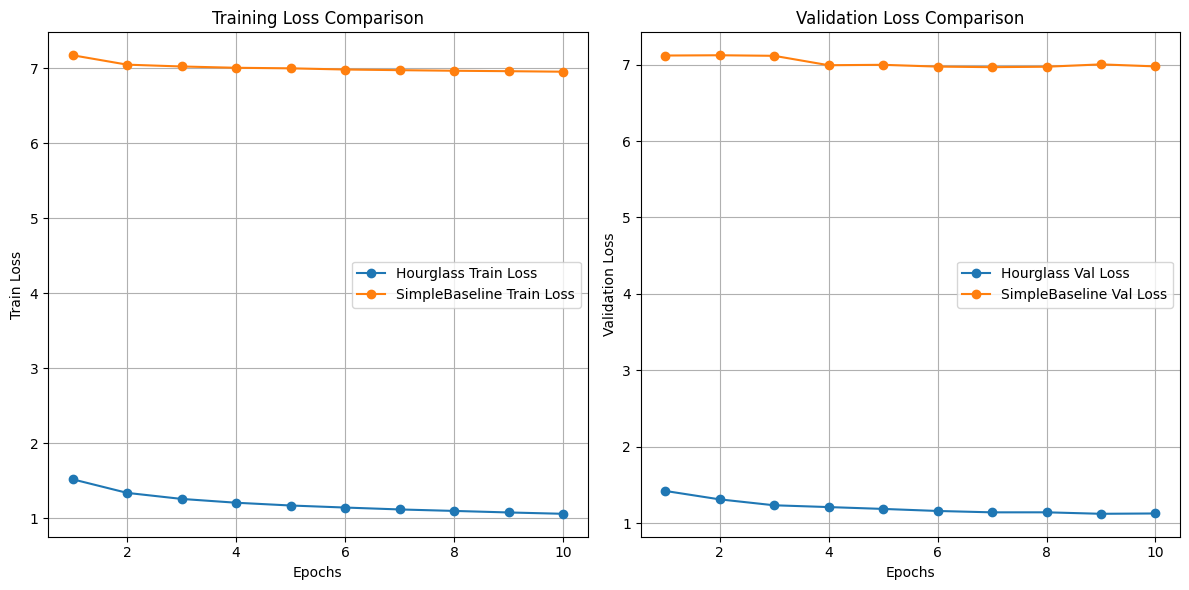

In [35]:
import matplotlib.pyplot as plt

# 에포크 수: 각 모델의 history 길이에 따라 설정 (예시로 두 모델 모두 동일한 에포크 수라고 가정)
epochs_hg = range(1, len(history["train_loss"]) + 1)    # 모래시계 모델의 history
epochs_sb = range(1, len(history_sb["train_loss"]) + 1)   # SimpleBaseline 모델의 history_sb

plt.figure(figsize=(12, 6))

# 학습 손실 비교 (Train Loss)
plt.subplot(1, 2, 1)
plt.plot(epochs_hg, history["train_loss"], label="Hourglass Train Loss", marker="o")
plt.plot(epochs_sb, history_sb["train_loss"], label="SimpleBaseline Train Loss", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Train Loss")
plt.title("Training Loss Comparison")
plt.legend()
plt.grid(True)

# 검증 손실 비교 (Validation Loss)
plt.subplot(1, 2, 2)
plt.plot(epochs_hg, history["val_loss"], label="Hourglass Val Loss", marker="o")
plt.plot(epochs_sb, history_sb["val_loss"], label="SimpleBaseline Val Loss", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Validation Loss")
plt.title("Validation Loss Comparison")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

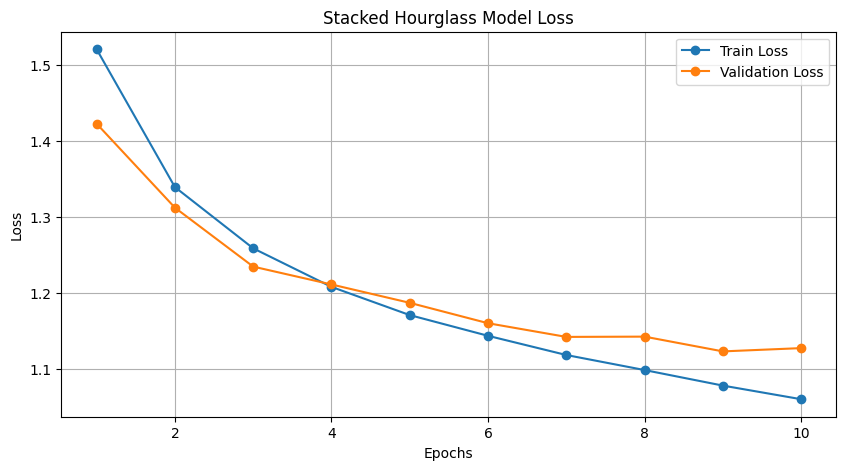

In [36]:
import matplotlib.pyplot as plt

# 에포크 수 설정
epochs_hg = range(1, len(history["train_loss"]) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs_hg, history["train_loss"], label="Train Loss", marker="o")
plt.plot(epochs_hg, history["val_loss"], label="Validation Loss", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Stacked Hourglass Model Loss")
plt.legend()
plt.grid(True)
plt.show()

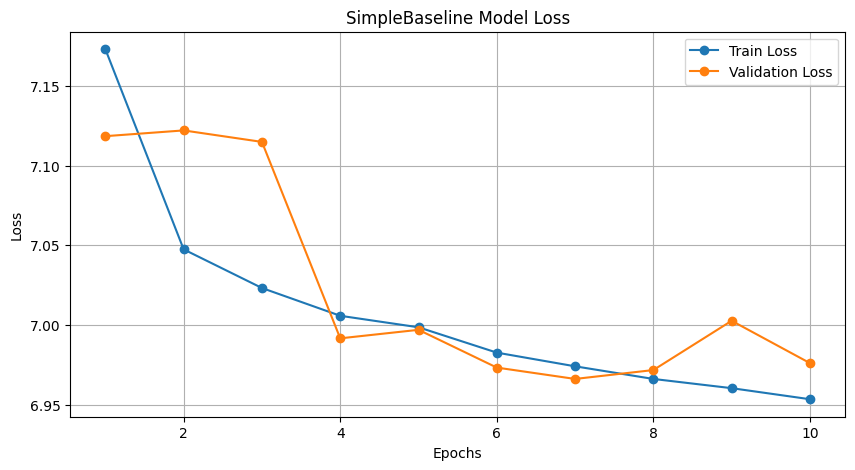

In [37]:
import matplotlib.pyplot as plt

# 에포크 수 설정
epochs_sb = range(1, len(history_sb["train_loss"]) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs_sb, history_sb["train_loss"], label="Train Loss", marker="o")
plt.plot(epochs_sb, history_sb["val_loss"], label="Validation Loss", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("SimpleBaseline Model Loss")
plt.legend()
plt.grid(True)
plt.show()

10 에포크로도 과대적합을 판단하기에는 애매했다

In [28]:
R_ANKLE = 0
R_KNEE = 1
R_HIP = 2
L_HIP = 3
L_KNEE = 4
L_ANKLE = 5
PELVIS = 6
THORAX = 7
UPPER_NECK = 8
HEAD_TOP = 9
R_WRIST = 10
R_ELBOW = 11
R_SHOULDER = 12
L_SHOULDER = 13
L_ELBOW = 14
L_WRIST = 15

MPII_BONES = [
    [R_ANKLE, R_KNEE],
    [R_KNEE, R_HIP],
    [R_HIP, PELVIS],
    [L_HIP, PELVIS],
    [L_HIP, L_KNEE],
    [L_KNEE, L_ANKLE],
    [PELVIS, THORAX],
    [THORAX, UPPER_NECK],
    [UPPER_NECK, HEAD_TOP],
    [R_WRIST, R_ELBOW],
    [R_ELBOW, R_SHOULDER],
    [THORAX, R_SHOULDER],
    [THORAX, L_SHOULDER],
    [L_SHOULDER, L_ELBOW],
    [L_ELBOW, L_WRIST]
]

print('슝=3')

슝=3


In [29]:
def find_max_coordinates(heatmaps):
    flatten_heatmaps = tf.reshape(heatmaps, (-1, 16))
    indices = tf.math.argmax(flatten_heatmaps, axis=0)
    y = tf.cast(indices / 64, dtype=tf.int64)
    x = indices - 64 * y
    return tf.stack([x, y], axis=1).numpy()

print('슝=3')

슝=3


In [30]:
def extract_keypoints_from_heatmap(heatmaps):
    max_keypoints = find_max_coordinates(heatmaps)

    padded_heatmap = np.pad(heatmaps, [[1,1],[1,1],[0,0]], mode='constant')
    adjusted_keypoints = []
    for i, keypoint in enumerate(max_keypoints):
        max_y = keypoint[1]+1
        max_x = keypoint[0]+1
        
        patch = padded_heatmap[max_y-1:max_y+2, max_x-1:max_x+2, i]
        patch[1][1] = 0
        
        index = np.argmax(patch)
        
        next_y = index // 3
        next_x = index - next_y * 3
        delta_y = (next_y - 1) / 4
        delta_x = (next_x - 1) / 4
        
        adjusted_keypoint_x = keypoint[0] + delta_x
        adjusted_keypoint_y = keypoint[1] + delta_y
        adjusted_keypoints.append((adjusted_keypoint_x, adjusted_keypoint_y))
        
    adjusted_keypoints = np.clip(adjusted_keypoints, 0, 64)
    normalized_keypoints = adjusted_keypoints / 64
    return normalized_keypoints

print('슝=3')

슝=3


In [31]:
def predict(model, image_path):
    encoded = tf.io.read_file(image_path)
    image = tf.io.decode_jpeg(encoded)
    inputs = tf.image.resize(image, (256, 256))
    inputs = tf.cast(inputs, tf.float32) / 127.5 - 1
    inputs = tf.expand_dims(inputs, 0)
    outputs = model(inputs, training=False)
    if type(outputs) != list:
        outputs = [outputs]
    heatmap = tf.squeeze(outputs[-1], axis=0).numpy()
    kp = extract_keypoints_from_heatmap(heatmap)
    return image, kp

print('슝=3')

슝=3


In [32]:
def draw_keypoints_on_image(image, keypoints, index=None):
    fig,ax = plt.subplots(1)
    ax.imshow(image)
    joints = []
    for i, joint in enumerate(keypoints):
        joint_x = joint[0] * image.shape[1]
        joint_y = joint[1] * image.shape[0]
        if index is not None and index != i:
            continue
        plt.scatter(joint_x, joint_y, s=10, c='red', marker='o')
    plt.show()

def draw_skeleton_on_image(image, keypoints, index=None):
    fig,ax = plt.subplots(1)
    ax.imshow(image)
    joints = []
    for i, joint in enumerate(keypoints):
        joint_x = joint[0] * image.shape[1]
        joint_y = joint[1] * image.shape[0]
        joints.append((joint_x, joint_y))
    
    for bone in MPII_BONES:
        joint_1 = joints[bone[0]]
        joint_2 = joints[bone[1]]
        plt.plot([joint_1[0], joint_2[0]], [joint_1[1], joint_2[1]], linewidth=5, alpha=0.7)
    plt.show()

print('슝=3')

슝=3


In [33]:
test_image = os.path.join(PROJECT_PATH, 'test_image.jpg')

image, keypoints = predict(model, test_image)
draw_keypoints_on_image(image, keypoints)
draw_skeleton_on_image(image, keypoints)

NameError: name 'model' is not defined

# 회고

1. SimpleBaseline 모델이 구조가 좀 더 간단해서 그런지 수렴도 오래걸리고 StacekdHourglass 모델에 비해 성능도 잘 안나왔다.
2. 논문에서 언긊한 에포크가 거의 200가까이 였던 것 같아서, 학습을 더 돌려보고 싶었으나 쉽지 않았다.
3. 정성적인 평가를 진행하지 못해서 아쉬웠다.